<a href="https://colab.research.google.com/github/larcherg/-/blob/main/PF_%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_Logress_%D0%B8_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задача классификации физических лиц по уровню дохода

**Цель**: изучить применение модели логистической регрессии и метода опорных векторов в задаче бинарной классификации.

Данные для обучения модели хранятся в файле adult.csv, который можно скачать с сайта https://www.cs.toronto.edu/~delve/data/adult/desc.html.

Целевая переменная – уровень дохода income, который принимает два значения <=50K и >50K, поэтому классификация бинарная. Остальные признаки описывают персональную информацию – возраст, образование, семейное положение и т. д. Подробное описание признаков можно прочитать по ссылке http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

### Загрузка и предобработка данных

In [ ]:
data = pd.read_csv('Dataset.data', sep=' ',
                  names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num','marital-status', 'occupation', 'relationship', 
                           'race', 'sex', 'capital-gain','capital-loss', 'hours-per-week', 'native-country', 'income'])
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [ ]:
data.nunique()

age                  74
workclass             9
fnlwgt            28523
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        123
capital-loss         99
hours-per-week       96
native-country       42
income                2
dtype: int64

Удалим строки с пропусками, их немного в процентном соотношении, не должно повлиять на результат:

In [ ]:
data = data[(data['workclass'] != '?')]
data = data[(data['occupation'] != '?')]
data = data[(data['native-country'] != '?')]

Столбцы education и education_num дублируют друг друга, оставим количественное значениe education_num:

In [ ]:
data = data.drop('education', axis=1)

Также можно удалить столбцы capital-gain и capital-loss, так как 90% значений в них = 0? Можно? Пока оставила

In [ ]:
#data = data.drop(['capital-gain', 'capital-loss'], axis=1)

In [ ]:
data.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


### Визуализация исследуемых данных

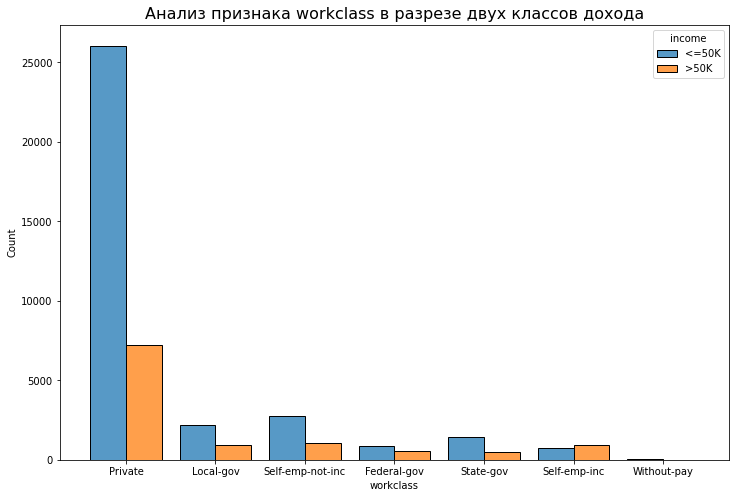

In [ ]:
fig = plt.subplots(figsize=(12, 8))
plt.title('Анализ признака workclass в разрезе двух классов дохода', fontsize=16)
sns.histplot(data=data, x='workclass', hue='income', multiple="dodge", shrink=0.8)
plt.show() 

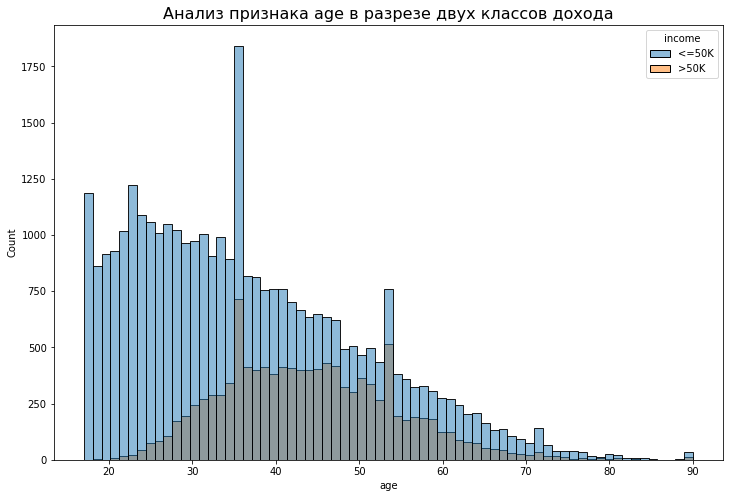

In [ ]:
fig = plt.subplots(figsize=(12, 8))
plt.title('Анализ признака age в разрезе двух классов дохода', fontsize=16)
sns.histplot(data=data, x='age', hue='income')
plt.show() 

**Выводы:**

По графикам видно, что распределение по 2 классам дохода зависит от места работы и возраста.

Например, у людей с местом работы Federal-gov большинство имее доход > 50К, в остальных группах таких людей меньшинство.

Большинство людей имеют доход <= 50К в любой возрастной группе, но в возрастной группе 35-60 лет  % людей с доходом > 50К больше.


### Преобразование категориальных признаков в количественные

In [ ]:
# уберем целевой столбец
X = data.drop('income', axis=1)

In [ ]:
X = pd.get_dummies(X, columns=['workclass','marital-status', 'occupation', 'race', 'sex', 'relationship', 'native-country'])
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,226802,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,38,89814,9,0,0,50,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,28,336951,12,0,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,44,160323,10,7688,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,34,198693,6,0,0,30,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
from sklearn.preprocessing import LabelEncoder

# кодируем целевой столбец: 0 - <=50К, 1 - > 50К 
y = pd.Series(LabelEncoder().fit_transform(data['income']))
y.head() 

0    0
1    0
2    1
3    1
4    0
dtype: int64

### Разделение выборки на обучающее и тестовое подмножество

In [ ]:
from sklearn.model_selection import train_test_split 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Логистическая регрессия

In [ ]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=200)
)

In [ ]:
# обучение модели
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=200))])

In [ ]:
# предсказания модели на тестовой выборке
predictions = model.predict(X_test)
predictions[:20]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [ ]:
model.predict_proba(X_test)  # вероятность попадания элемента выборки в класс 0 и 1

array([[0.99820617, 0.00179383],
       [0.93395825, 0.06604175],
       [0.54082607, 0.45917393],
       ...,
       [0.7861418 , 0.2138582 ],
       [0.82391256, 0.17608744],
       [0.989663  , 0.010337  ]])

In [ ]:
# точность предсказания  - 85% - неплохой результат
model.score(X_test, y_test)

0.8506357103372029

### Метод опорных векторов  (SVM)

In [ ]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

model = make_pipeline(
    StandardScaler(),
    SVC(max_iter=300)
)

In [ ]:
# обучение модели
model.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(max_iter=300))])

In [ ]:
# предсказания модели на тестовой выборке
predictions = model.predict(X_test)
predictions[:20]

array([0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1])

In [ ]:
# точность предсказания - 65% - очень низкая - модель плохая
model.score(X_test, y_test)

0.6543946932006633

**Выводы:**

Из двух обученных моделей хороший результат показала только модель Логистической регрессии. 

Точность предсказания модели SVM очень низкая, поэтому не целесообразно использовать эту модель. Пробовала менять количество итераций, при других значениях результат еще хуже. Также пробовала разные ядра, тоже результат ухудшался.

Для улучшения точности модели Логистической регрессии возможно стоит еще поработать с исходными данными. Увеличение/уменьшение количества итераций точность не улучшило.